### Description (ENG)

The time has come to analyze the results of the experiment that we conducted together with the data scientist team. The experiment took place from 2023-08-29 to 2023-09-04 inclusive. The experiment involved 2 and 1 groups.

Group 2 used one of the new post recommendation algorithms, group 1 was used as a control.

The main hypothesis is that the new algorithm in group 2 will lead to an increase in CTR.

Our task is to analyze the A/B test data.

**Task:**

1. Select an analysis method and compare CTR in two groups (we analyzed t-test, Poisson bootstrap, Mann-Whitney test, t-test on smoothed CTR (α=5) as well as t-test and Mann-Whitney test over bucket transformation).
2. Compare the data with these tests. Also, look at the distributions with your eyes. Why did the tests work the way they did?
3. Describe a potential situation where such a change could occur. There is no perfect answer, think about it.
4. Write a recommendation whether we should roll out the new algorithm to all new users or whether it’s not worth it.

### Description (RUS)

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-08-29 по 2023-09-04 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные А/B-теста. 

**Задание:**

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном CTR (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set_style('darkgrid')

In [3]:
import swifter # to accelerate .apply() method
from scipy import stats

import pandahouse 

In [4]:
# Parameters to connect to ClickHouse DB
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230920'} 

In [5]:
# Query to select data for 1, 2 experimental group at the corresponding dates
q = """
SELECT exp_group, user_id, sum(action = 'like') AS likes, sum(action = 'view') AS views, likes/views AS ctr
FROM {db}.feed_actions
WHERE toDate(time) >= '2023-08-29' AND toDate(time) <= '2023-09-04' AND exp_group IN (1, 2)
GROUP BY exp_group, user_id
"""

In [6]:
df_users = pandahouse.read_clickhouse(q, connection=connection)

In [7]:
df_users.head(3)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575


In [8]:
# Let's divide the groups into 2 separate dataframes
group_1 = df_users[df_users.exp_group == 1].copy()
group_2 = df_users[df_users.exp_group == 2].copy()
group_1.user_id.nunique(), group_2.user_id.nunique() # и посмотрим как соотносятся размеры групп

(10020, 9877)

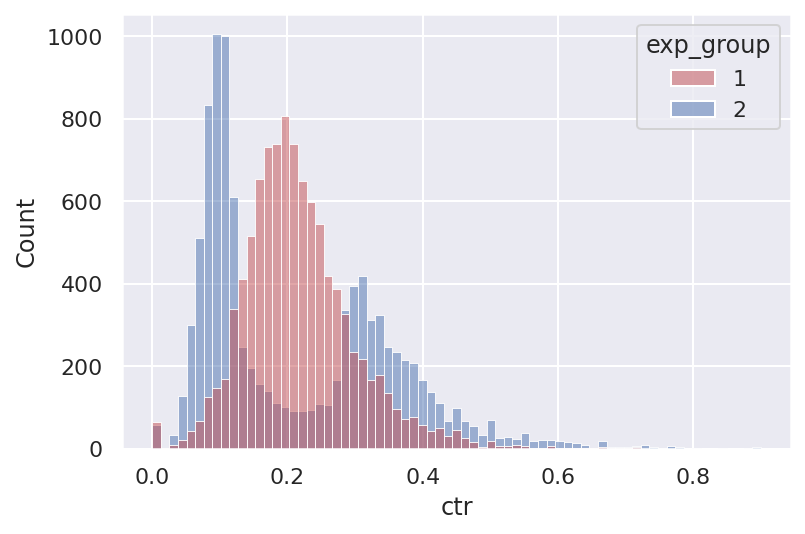

In [9]:
# Let's look visually at the distributions of these two groups
sns.set(rc={'figure.figsize':(8,4)})

groups = sns.histplot(data = df_users, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

**It is immediately clear that the distributions do not visually coincide, and the distribution of the second group is far from being Normal - there are two peaks $\Rightarrow$ problems will arise with the use of the t-test.**

Let's carry out a t-test:

In [10]:
stats.ttest_ind(group_1.ctr,
                group_2.ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

**Conclusion:** the t-test accepts the null hypothesis at any standard significance level (p-value $\approx$ 0.69), although the distribution graph shows that there are differences $\Rightarrow$ **t-test does not work correctly** . This can be explained by the fact that the t-test tests the equality of means in two groups. The distribution of the second group has two peaks, so the average CTR value for this group will lie exactly in the middle between these peaks at approximately 0.2, which will coincide with the average CTR value for the control first group. This is the equality of means and is shown by the t-test.

In [10]:
# Mann-Whitney test
stats.mannwhitneyu(group_1.ctr, 
                   group_2.ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

**Conclusion:** the Mann-Whitney test rejects the null hypothesis at any standard level of significance (p-value is negligible) $\Rightarrow$ there are statistically significant differences between the groups. **The test works correctly**, because for the Mann-Whitney test it does not matter what distributions are received as input.

### Smoothed CTR

Let's try a t-test for the smoothed CTR.

In [11]:
# Let's define a function to evaluate the smoothed CTR
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    return (user_likes + alpha * global_ctr) / (user_views + alpha)

In [12]:
global_ctr_1 = group_1.likes.sum()/group_1.views.sum()
global_ctr_2 = group_2.likes.sum()/group_2.views.sum()

group_1['smothed_ctr'] = group_1.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group_2['smothed_ctr'] = group_2.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

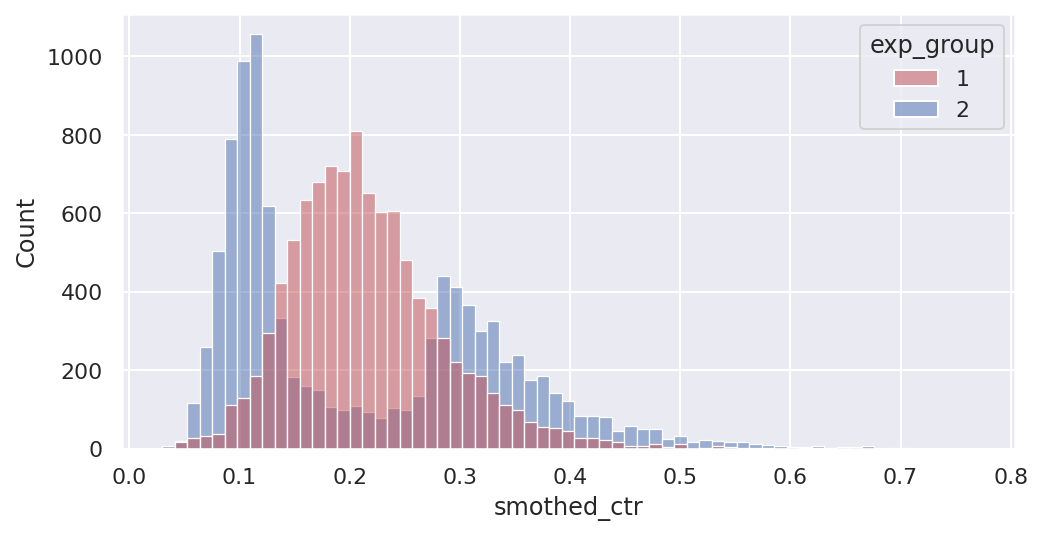

In [13]:
sns.set(rc={'figure.figsize':(8, 4)})
groups = sns.histplot(data = pd.concat([group_1, group_2]), 
              x='smothed_ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

For the smoothed CTR, we obtained approximately the same picture of the distribution of the first and second groups.

In [14]:
# t-test for the smoothed CTR
stats.ttest_ind(group_1.smothed_ctr,
                group_2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

**Conclusion**: thus, when we consider smoothed CTR as a metric, the null hypothesis is already “almost” rejected by the t-test at a significance level of 5% (p-value $\approx$ 0.05).

### Poisson bootstrap

Let's analyze the difference between the two groups using Poisson bootstrap.

In [15]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [16]:
likes1 = group_1.likes.to_numpy()
views1 = group_1.views.to_numpy()
likes2 = group_2.likes.to_numpy()
views2 = group_2.views.to_numpy()

In [17]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<Axes: ylabel='Count'>

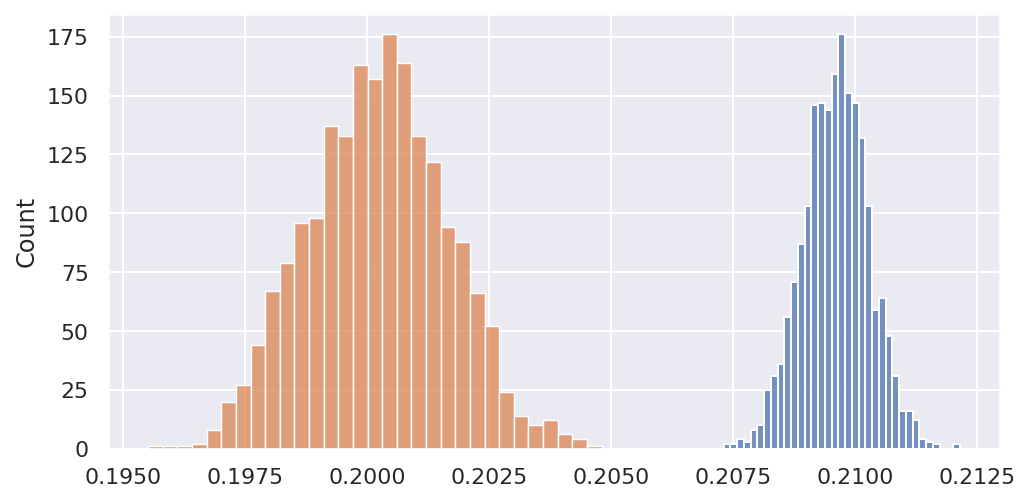

In [18]:
sns.histplot(ctr1)
sns.histplot(ctr2)

It can be seen that the distributions do not intersect => there is a difference.

<Axes: ylabel='Count'>

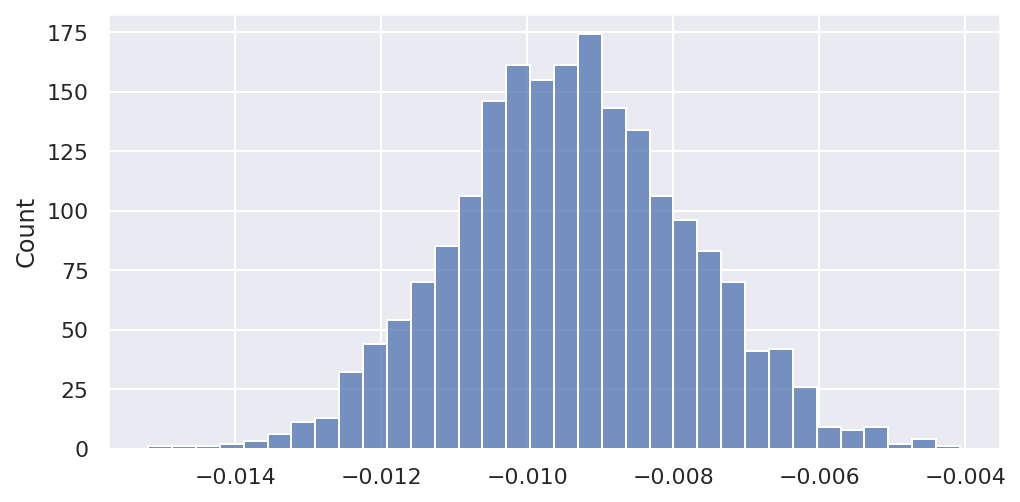

In [19]:
# The difference between CTR
sns.histplot(ctr2 - ctr1)

**Conclusion**: thus, in general, the algorithm led to a decrease in CTR in the second group compared to the control.

### Results

**Conclusion:** the introduction of a new post recommendation algorithm influenced the distribution of CTR in the second group compared to the control group, which is confirmed by statistical tests. If you look at the distribution graph of the 2nd experimental group, it is easy to notice that its users can be divided into two parts - in one part the average CTR increased, in the other it fell (compared to the control group). Moreover, according to the bootstrap, the implementation of the algorithm led to a decrease in CTR in general. Perhaps this division of users into two camps is due to the fact that the new algorithm somehow incorrectly issued recommendations on one of the two operating systems (and the most popular one) and offered users posts that were not interesting to them. Or, for example, the algorithm did not take into account geolocation and rolled out posts to users from different regions of Russia about goods/services in Moscow (for example), which is why the algorithm worked well for Muscovites, but caused a negative reaction among residents of the regions. In any case, additional research is required to determine the reasons for the drop in CTR, but for now we can say for sure that it is not worth rolling out the algorithm on new users.

